## Final Project Submission

Please fill out:
* Student name: __Joshua Ko__
* Student pace: self paced / __part time__ / full time
* Scheduled project review date/time: 
* Instructor name: __Mark Barbour__
* Blog post URL: https://medium.com/@joshuawko/creating-logistic-regressions-70e8541acbe9


# Goal: What is the appropriate price of a home?
Whether you are buying or selling a property, pricing will either make or break a decision to buy or sell a home. As sellers wish to maximize their profits, if they are too unreasonable with their price, they will not find a buyer. The objective is to mathmatically and statistically determine the appropriate price of a home given certain conditions. We will be investigating the homes in Kings County, Seattle. As the results may not be identical to other locations, the methodology should be analogous.

# Import libraries and load dataset

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, StrMethodFormatter

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [2]:
cd \Users\joshu\Documents\Flatiron\phase_2\phase2_project-\data

C:\Users\joshu\Documents\Flatiron\phase_2\phase2_project-\data


In [3]:
df = pd.read_csv("kc_house_data.csv", index_col=0)
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000
mean,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,1809.826098,476.039396,330.211142,217.412038,1975.163953,90.922301,47.328076,-121.317397
std,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,878.306131,579.631302,285.770536,245.302792,32.067362,416.473038,1.434005,5.725475
min,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,21.274240,-157.791480
25%,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,47.405320,-122.326045
50%,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,47.551380,-122.225585
75%,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,47.669913,-122.116205
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,64.824070,-70.074340


# Cleaning the dataset
Some of the data were not inside King County, Seattle and did not make sense (`sqft_living` being 0 or some other small value).

In [4]:
df = df.drop(df[(df.lat < 47) | (df.lat > 48)].index)
df = df.drop(df[(df.long < -123) | (df.long > -120)].index)
df = df.drop(df[(df.sqft_living) < 100].index)
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,2.922600e+04,29226.000000,29226.000000,29226.000000,2.922600e+04,29226.000000,29226.000000,29226.000000,29226.000000,29226.000000,29226.000000,29226.000000,29226.000000,29226.000000
mean,1.112497e+06,3.435229,2.331948,2130.781222,1.718798e+04,1.516697,1825.895196,480.695237,336.326216,216.331280,1973.855540,93.812427,47.543087,-122.214206
std,8.953861e+05,0.978746,0.895753,977.251199,6.124692e+04,0.548202,880.709571,585.959029,286.214143,246.721313,31.676635,422.720060,0.146283,0.143620
min,2.736000e+04,0.000000,0.000000,100.000000,4.020000e+02,1.000000,100.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,47.000860,-122.526650
25%,6.450000e+05,3.000000,2.000000,1440.000000,5.000000e+03,1.000000,1190.000000,0.000000,0.000000,40.000000,1952.000000,0.000000,47.430081,-122.328324
50%,8.670000e+05,3.000000,2.500000,1940.000000,7.560000e+03,1.500000,1580.000000,0.000000,400.000000,140.000000,1976.000000,0.000000,47.557643,-122.234133
75%,1.310000e+06,4.000000,3.000000,2640.000000,1.078000e+04,2.000000,2290.000000,960.000000,510.750000,310.000000,2001.000000,0.000000,47.672004,-122.127488
max,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,47.876700,-121.163960


We will also create a new column, `total rooms`, that combines `bedrooms` and `bathrooms`. This column will be used later when we group the data according to the number of rooms in a home.

In [5]:
df["total rooms"] = df.bedrooms + df.bathrooms

In [6]:
df.corr()["price"]

price            1.000000
bedrooms         0.291035
bathrooms        0.487887
sqft_living      0.616590
sqft_lot         0.085881
floors           0.199787
sqft_above       0.546090
sqft_basement    0.246344
sqft_garage      0.267813
sqft_patio       0.317203
yr_built         0.106078
yr_renovated     0.085303
lat              0.297751
long             0.080300
total rooms      0.431157
Name: price, dtype: float64

We can see that `price` is moderately correlated to `sqft_living`. So we can set our independent variable as `sqft_living` and our dependent variable as `price`.

## Finding outliers

We can determine the outliers of the data in hopes of obtaining a greater correlation value.

In [7]:
def outlier(dataframe):
    q1 = np.quantile(dataframe, 0.25)
    q3 = np.quantile(dataframe, 0.75) 
    iqr = q3-q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr

    outliers = dataframe[(dataframe<lower_bound) | (dataframe>upper_bound)]
    print("Lower bound: ", lower_bound, "\n" "Upper bound: ", upper_bound)

In [8]:
outlier(df["price"])

Lower bound:  -352500.0 
Upper bound:  2307500.0


In [9]:
df_no_outliers = df.drop(df[(df.price > 2307500.0)].index)
df_no_outliers.corr()["price"]

price            1.000000
bedrooms         0.314782
bathrooms        0.438810
sqft_living      0.567144
sqft_lot         0.074442
floors           0.221466
sqft_above       0.480655
sqft_basement    0.204113
sqft_garage      0.236379
sqft_patio       0.248973
yr_built         0.090083
yr_renovated     0.053474
lat              0.426918
long             0.131733
total rooms      0.419407
Name: price, dtype: float64

After removing the outliers, the correlation value of `sqft_living` has decreased. This makes the outliers influential and therefore should remain in the dataset.

# Housing Market
Understanding the housing market is important in selling/purchasing a home. We can observe how the prices of homes change by organizing the data by the date purchased/sold. We can create a null hypothesis and alternative hypothesis and perform a z-test to see if the null hypothesis can be rejected.

$H_0\text{: The market shows no significant change as we go through the fiscal quarters.}$

$H_a\text{: The market demonstrates notable change for each passing fiscal quarter.}$
___

First we have to make sure the date in the dataframe is formated correctly so that the dataset can be separated into quarters.

In [10]:
df.dtypes

date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront        object
greenbelt         object
nuisance          object
view              object
condition         object
grade             object
heat_source       object
sewer_system      object
sqft_above         int64
sqft_basement      int64
sqft_garage        int64
sqft_patio         int64
yr_built           int64
yr_renovated       int64
address           object
lat              float64
long             float64
total rooms      float64
dtype: object

In [11]:
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")
df.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,total rooms
id,,,,,,,,,,,,,,,,,,,,,
7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,...,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,5.0
8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,...,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,7.5
1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,...,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,8.0


Now we can break up the dataset into their respective fiscal quarters.

In [12]:
q1_2021 = df.loc[(df["date"] >= "2021-01-01") & (df["date"] <= "2021-03-31")]
q2_2021 = df.loc[(df["date"] >= "2021-04-01") & (df["date"] <= "2021-06-30")]
q3_2021 = df.loc[(df["date"] >= "2021-07-01") & (df["date"] <= "2021-09-30")]
q4_2021 = df.loc[(df["date"] >= "2021-10-01") & (df["date"] <= "2021-12-31")]

q1_2022 = df.loc[(df["date"] >= "2022-01-01") & (df["date"] <= "2022-03-31")]
q2_2022 = df.loc[(df["date"] >= "2022-04-01") & (df["date"] <= "2022-06-30")]
q3_2022 = df.loc[(df["date"] >= "2022-07-01") & (df["date"] <= "2022-09-30")]
q4_2022 = df.loc[(df["date"] >= "2022-10-01") & (df["date"] <= "2022-12-31")]

Upon investigation, `q1_2021`, `q3_2022`, and `q4_2022` had no values and therefore those dataframes will be omitted for the rest of the procedure.

## Calculating Z-Scores

We will be performing a z-test due to the number of samples. However, the data must be normally distributed. This can be done by taking the __log__ or __square root__ of the data.
___

A function that returns a distribution plot is made. We can then determine if it is normally distributed; if it is not we can alter the data values.

In [13]:
def distribution(df): 
    return sns.histplot(df, kde=True, bins=100);

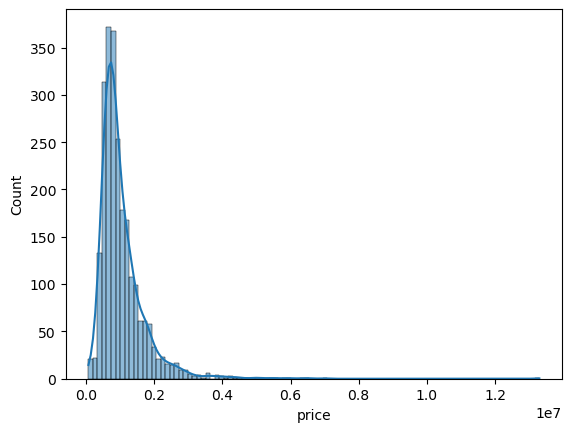

In [14]:
distribution(q2_2021["price"]);

Because the data is skewed to the right, we can fix this by taking the `log` of the data values.

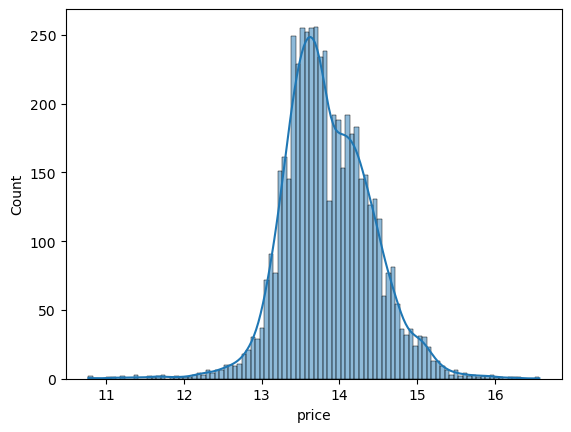

In [15]:
distribution(np.log(q2_2022["price"]));

Once the data is normally distributed, a new dataset with the means, standard deviation, number of samples, and the Z value is created for each fiscal quarter.

In [16]:
quarters = [["Q2 2021", np.log(q2_2021["price"]).mean()],
            ["Q3 2021", np.log(q3_2021["price"]).mean()],
            ["Q4 2021", np.log(q4_2021["price"]).mean()],
            ["Q1 2022", np.log(q1_2022["price"]).mean()],
            ["Q2 2022", np.log(q2_2022["price"]).mean()]]

In [17]:
quarter_df = pd.DataFrame(quarters, columns=["Quarters", "Average Log(Price)"])

In [18]:
quarter_df["STD"] = [np.log(q2_2021["price"]).std(),
                     np.log(q3_2021["price"]).std(),
                     np.log(q4_2021["price"]).std(),
                     np.log(q1_2022["price"]).std(),
                     np.log(q2_2022["price"]).std()]

quarter_df["Samples"] = [len(q2_2021),
                         len(q3_2021),
                         len(q4_2021),
                         len(q1_2022),
                         len(q2_2022)]

To calculate the z-score in order to demonstrate statistical signficance, we can use this formula:
# $$Z = \frac{\bar{x}-\mu}{\frac{\sigma}{\sqrt{n}}}$$
$\bar{x}$ = sample mean that can be calculated by taking a sample from the dataset.
<br>$\mu$ = mean of the population
<br>$\sigma$ = standard deviation of the population
<br>n = number of data in sample
___

The formula to calculate the z-score is translated to a function.

In [19]:
def Z_score(dataframe):
    df_sample = dataframe.sample(frac=0.5)
    x = np.log(df_sample).mean()
    mu = np.log(dataframe).mean()
    n = len(dataframe)/2
    sigma = np.log(dataframe).std()
    Z = abs(x - mu)/ (sigma/np.sqrt(n))
    return Z

In [20]:
quarter_df["Z score"] = [Z_score(q2_2021["price"]),
                         Z_score(q3_2021["price"]),
                         Z_score(q4_2021["price"]),
                         Z_score(q1_2022["price"]),
                         Z_score(q2_2022["price"])]

In [21]:
quarter_df

,Quarters,Average Log(Price),STD,Samples,Z score
0,Q2 2021,13.714077,0.533131,2403,0.393086
1,Q3 2021,13.704974,0.574589,9175,0.369522
2,Q4 2021,13.681178,0.593040,7090,0.301166
3,Q1 2022,13.765238,0.620185,5223,0.715068
4,Q2 2022,13.852192,0.567083,5335,0.824682


In order for a test to be statistically significant, a z-score of 1.645 or lower is needed for a p-value of 0.05. As each fiscal quarter yields a low z-score relative to the p-value, we can reject the null hypothesis as it should not fall within the 95% confidence interval.
___

We can now plot the averages to observe the trend of the housing market as we move through the fiscal quarters.

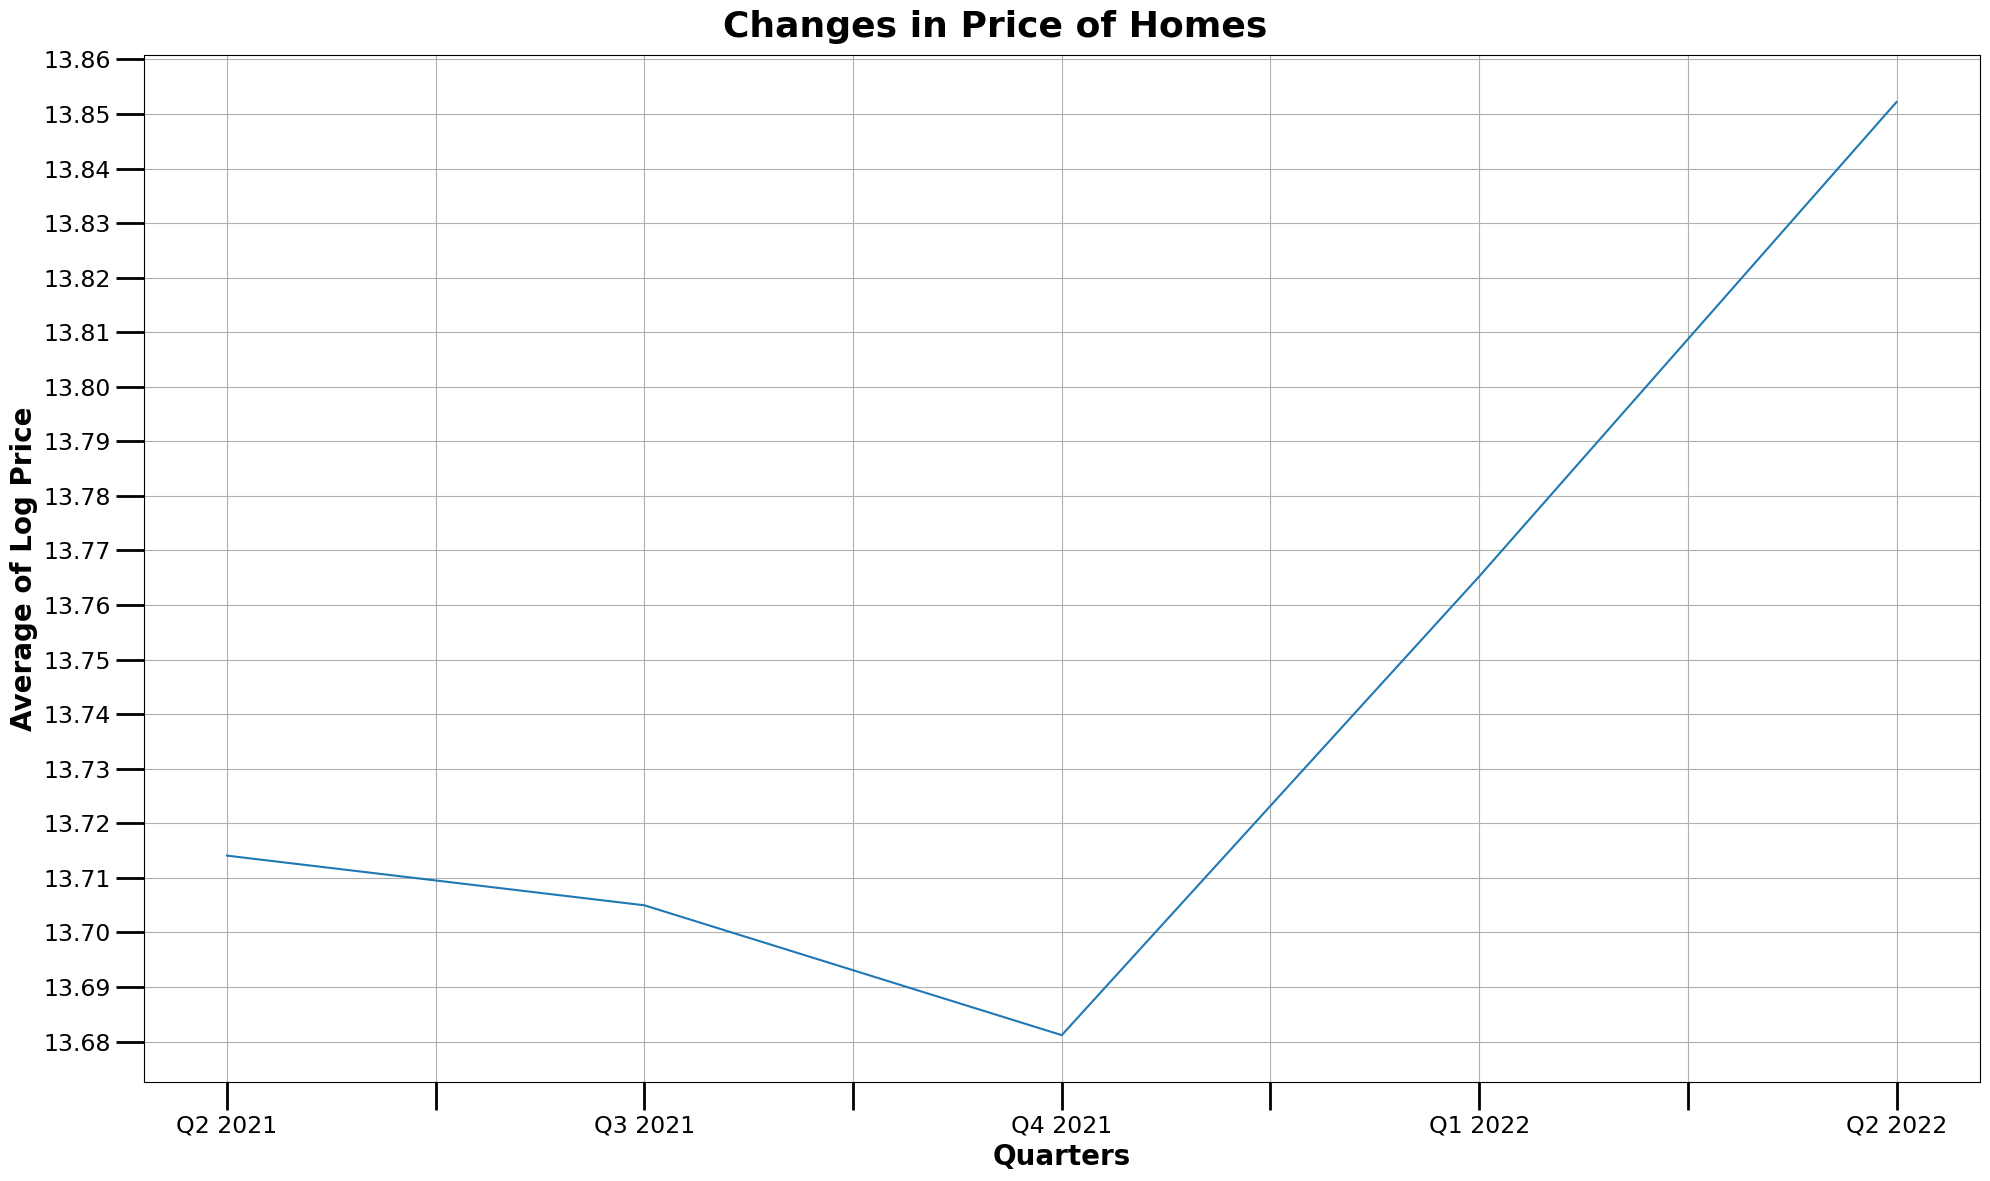

In [22]:
fig, ax = plt.subplots(figsize=(20,12), dpi=100)

quarter_df.plot.line(x="Quarters", y="Average Log(Price)", ax=ax)

ax.yaxis.set_major_locator(MultipleLocator(0.01))

ax.tick_params('both', length=20, width=2, which='major')

plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Changes in Price of Homes", fontweight='bold', fontsize=26)
ax.set_xlabel("Quarters", fontsize=20, fontweight='bold')
ax.set_ylabel("Average of Log Price", fontsize=20, fontweight='bold')
ax.get_legend().remove()
plt.grid()

plt.tight_layout();

The graph does show that the housing market did decrease towards the end of 2021. Further investigation can be made to determine what caused this decrease in price.
___
Because the log of the price returns a low p-value and is normally distributed, we will create a new column, `log_price` and work with the that column instead of the `price` column for the rest of the project. We then have to add the `log_price` column to the fiscal quarters dataframes.

In [23]:
df['log_price'] = np.log(df["price"])

q2_2021 = df.loc[(df["date"] >= "2021-04-01") & (df["date"] <= "2021-06-30")]
q3_2021 = df.loc[(df["date"] >= "2021-07-01") & (df["date"] <= "2021-09-30")]
q4_2021 = df.loc[(df["date"] >= "2021-10-01") & (df["date"] <= "2021-12-31")]
q1_2022 = df.loc[(df["date"] >= "2022-01-01") & (df["date"] <= "2022-03-31")]
q2_2022 = df.loc[(df["date"] >= "2022-04-01") & (df["date"] <= "2022-06-30")]

# Price vs. Square Feet of Living Space
As we have seen from `df.corr()`, `price` had the largest correlation value with `sqft_living`. A linear regression can be made by setting `X_baseline` as `sqft_living` and `y` as `price`. The correlation value is only `0.616590`, which shows moderate correlation. However, we can dive deeper and observe how prices change given a certain number of `total rooms`.
___

Using the `total rooms` column, we can group the data according to the number of rooms and see if homes with a certain number of rooms have a stronger correlation with `price` and `sqft_living`.

In [24]:
def total_rooms(dataframe):
    y = dataframe["total rooms"].value_counts(ascending=False)
    z = pd.DataFrame({'total rooms':y.index, 'count':y.values})
    corr = []
    rooms = dataframe.groupby(dataframe["total rooms"])
    for i in list(z["total rooms"]):
        x_rooms = rooms.get_group(i)
        corr.append(x_rooms.corr()["log_price"]["sqft_living"])
    z["correlation"] = corr
    return z

By running the dataframe for each quarter, the correlation for each corresponding `total rooms` is returned. Given the number of rooms in a home, we can see how `sqft_living` affects the `price`.

In [25]:
total_rooms(q2_2021)

,total rooms,count,correlation
0,6.5,409,0.487400
1,5.0,349,0.286924
2,5.5,333,0.462647
3,6.0,222,0.454278
4,4.0,203,0.324307
5,7.0,188,0.411756
6,3.0,146,0.198795
7,7.5,135,0.474683
8,8.0,105,0.577026
9,4.5,94,0.489921


In [26]:
total_rooms(q3_2021)

,total rooms,count,correlation
0,6.5,1370,0.467964
1,5.5,1325,0.485421
2,5.0,1307,0.372934
3,6.0,859,0.454583
4,4.0,837,0.394354
5,7.0,730,0.439814
6,3.0,530,0.204273
7,7.5,509,0.574035
8,4.5,420,0.405424
9,8.0,414,0.497690


In [27]:
total_rooms(q4_2021)

,total rooms,count,correlation
0,5.0,1082,0.356452
1,6.5,933,0.474159
2,5.5,922,0.453108
3,4.0,796,0.326872
4,6.0,636,0.422979
5,7.0,569,0.461031
6,3.0,446,0.201812
7,4.5,345,0.345767
8,7.5,339,0.528796
9,8.0,311,0.507601


In [28]:
total_rooms(q1_2022)

,total rooms,count,correlation
0,5.0,827,0.294394
1,5.5,753,0.456490
2,6.5,676,0.520847
3,4.0,555,0.274769
4,6.0,476,0.316194
5,3.0,389,0.251922
6,7.0,375,0.503446
7,4.5,283,0.342000
8,7.5,239,0.568249
9,8.0,195,0.498339


In [29]:
total_rooms(q2_2022)

,total rooms,count,correlation
0,5.0,837,0.344186
1,6.5,773,0.509644
2,5.5,769,0.486224
3,4.0,542,0.277589
4,6.0,472,0.367791
5,7.0,416,0.514092
6,3.0,357,0.217805
7,7.5,256,0.549703
8,4.5,246,0.458442
9,8.0,236,0.608095


We will choose homes with __8.0__ rooms because it has moderate correlation for each quarter and a high sample number.
___

The dataframes are set up by using `.groupby()`. By grouping the table by `total rooms`, we can then use `.get_group()` to only look at data with a certain number of `total rooms`. The number of rooms we will investigate is __8.0__.

In [30]:
q2_2021_rooms = q2_2021.groupby(q2_2021["total rooms"])
q3_2021_rooms = q3_2021.groupby(q3_2021["total rooms"])
q4_2021_rooms = q4_2021.groupby(q4_2021["total rooms"])
q1_2022_rooms = q1_2022.groupby(q1_2022["total rooms"])
q2_2022_rooms = q2_2022.groupby(q2_2022["total rooms"])

In [31]:
num_rooms = 8.0
q2_2021_x_rooms = q2_2021_rooms.get_group(num_rooms)
q3_2021_x_rooms = q3_2021_rooms.get_group(num_rooms)
q4_2021_x_rooms = q4_2021_rooms.get_group(num_rooms)
q1_2022_x_rooms = q1_2022_rooms.get_group(num_rooms)
q2_2022_x_rooms = q2_2022_rooms.get_group(num_rooms)

A function with the dataset as the input, and the return being the results of the model and mean square error which tells us how close the model is to the data.

In [32]:
def regression(dataframe):
    y = dataframe["log_price"]
    X_baseline = dataframe[["sqft_living"]]
    baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
    baseline_results = baseline_model.fit()
    return print(baseline_results.summary()), mean_squared_error(y, baseline_results.predict(sm.add_constant(X_baseline)), squared=False)

This function will allow us to create a linear model from the provided dataset. The output will then be used in the next function in order to plot the best-fit line.

In [33]:
def results(dataframe):
    x = dataframe[["sqft_living"]]
    y = dataframe[["log_price"]]
    model = sm.OLS(endog=y, exog=sm.add_constant(x))
    results=model.fit()
    return results

This function will allow us to create a scatterplot and the linear regression model.

In [34]:
def graph(dataframe):
    fig, ax = plt.subplots(figsize=(20,12), dpi=100)

    dataframe.plot.scatter(x="sqft_living", y="log_price", ax=ax)
    sm.graphics.abline_plot(model_results=results(dataframe), ax=ax)

    ax.set_facecolor("white")
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

    ax.tick_params('both', length=20, width=2, which='major')
    ax.tick_params('both', length=10, width=1, which='minor')
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)

    ax.set_xlabel("Square Feet", fontsize=20, fontweight='bold')
    ax.set_ylabel("Log of Price", fontsize=20, fontweight='bold')

    plt.tight_layout();

In [35]:
regression(q2_2021_x_rooms)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     51.41
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           1.17e-10
Time:                        20:24:50   Log-Likelihood:                -47.637
No. Observations:                 105   AIC:                             99.27
Df Residuals:                     103   BIC:                             104.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.8622      0.158     81.477      

(None, 0.38088552490687794)

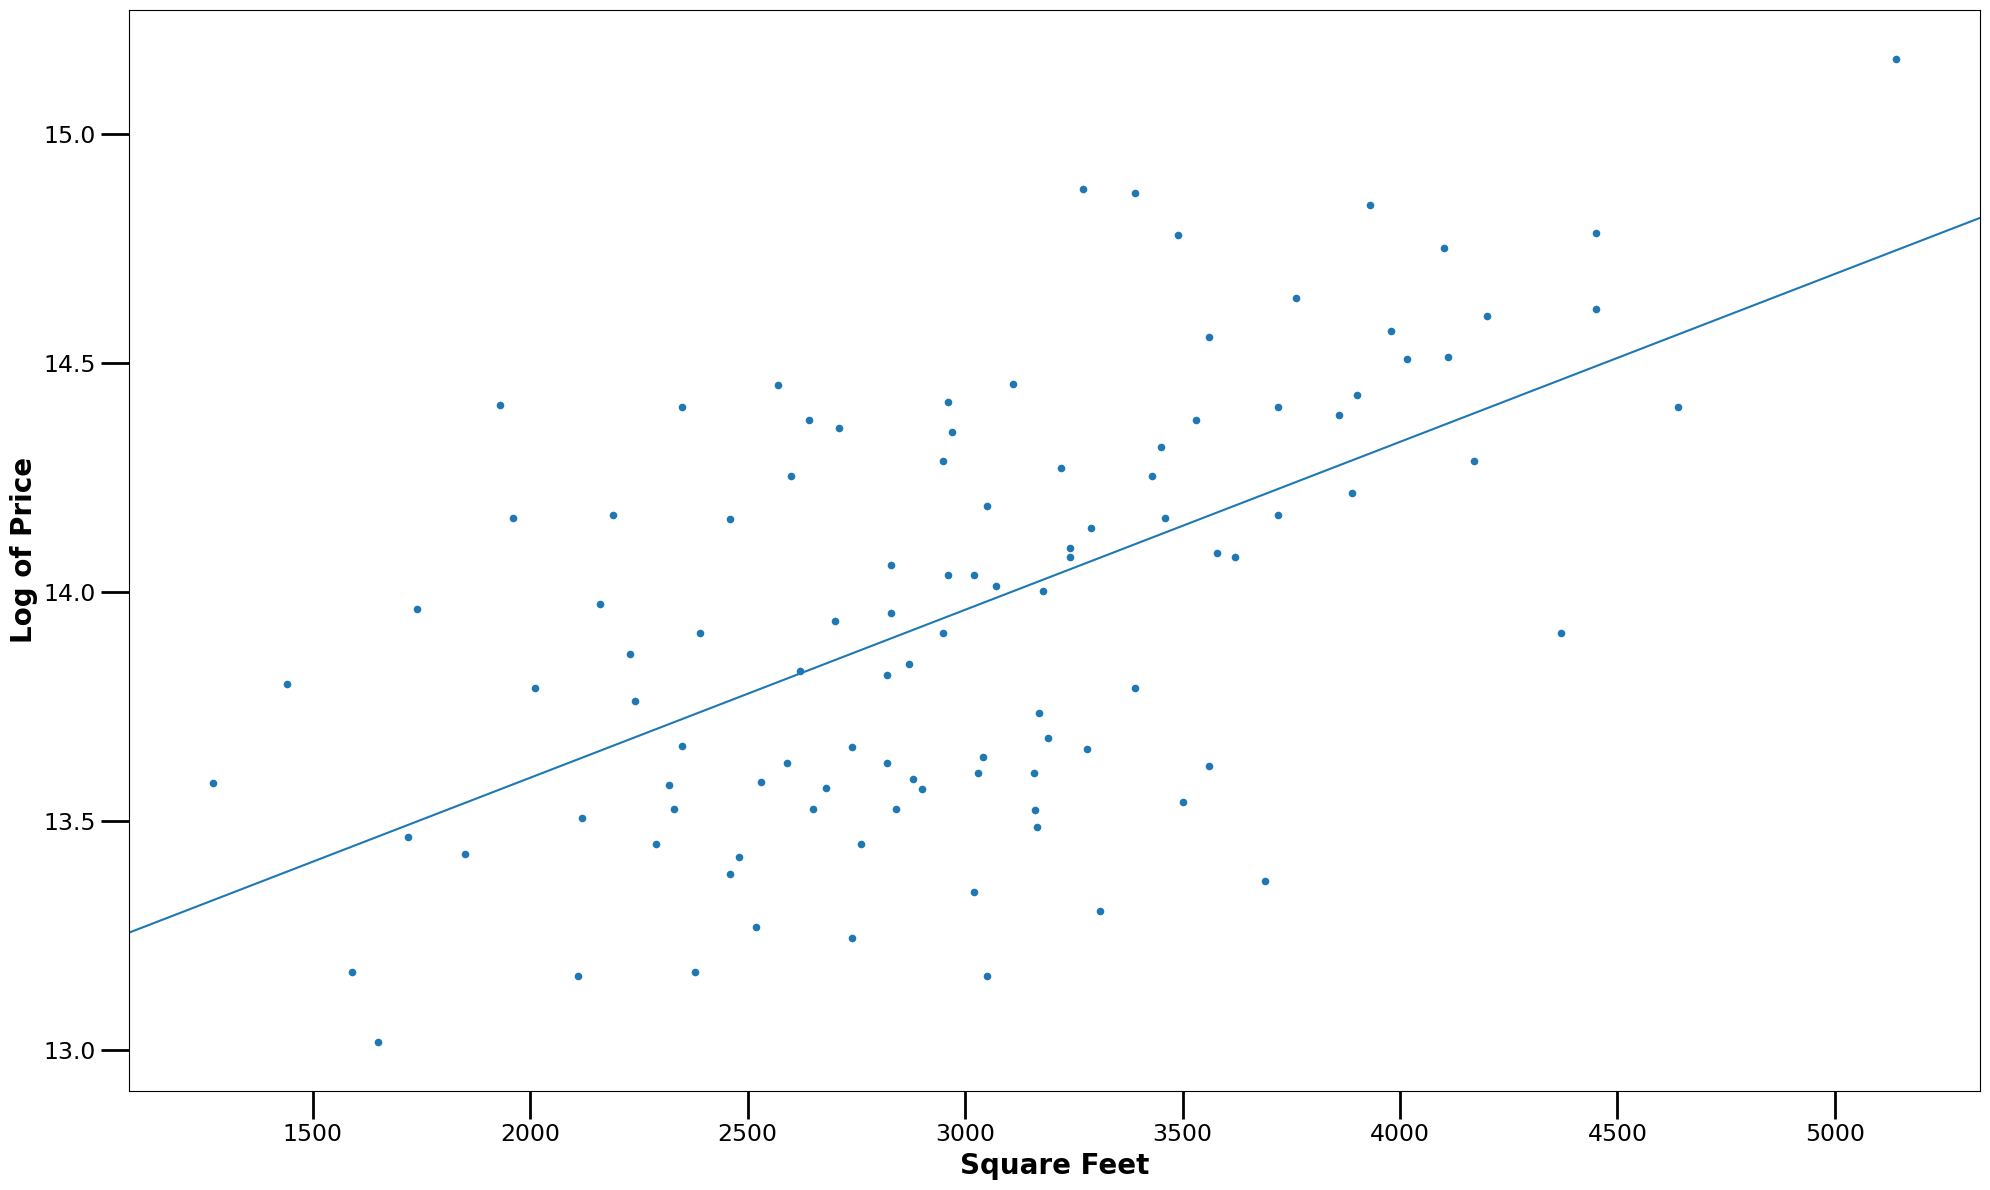

In [36]:
graph(q2_2021_x_rooms)

In [37]:
regression(q3_2021_x_rooms)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     135.7
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           2.70e-27
Time:                        20:24:52   Log-Likelihood:                -260.03
No. Observations:                 414   AIC:                             524.1
Df Residuals:                     412   BIC:                             532.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.8819      0.098    131.202      

(None, 0.453455784091846)

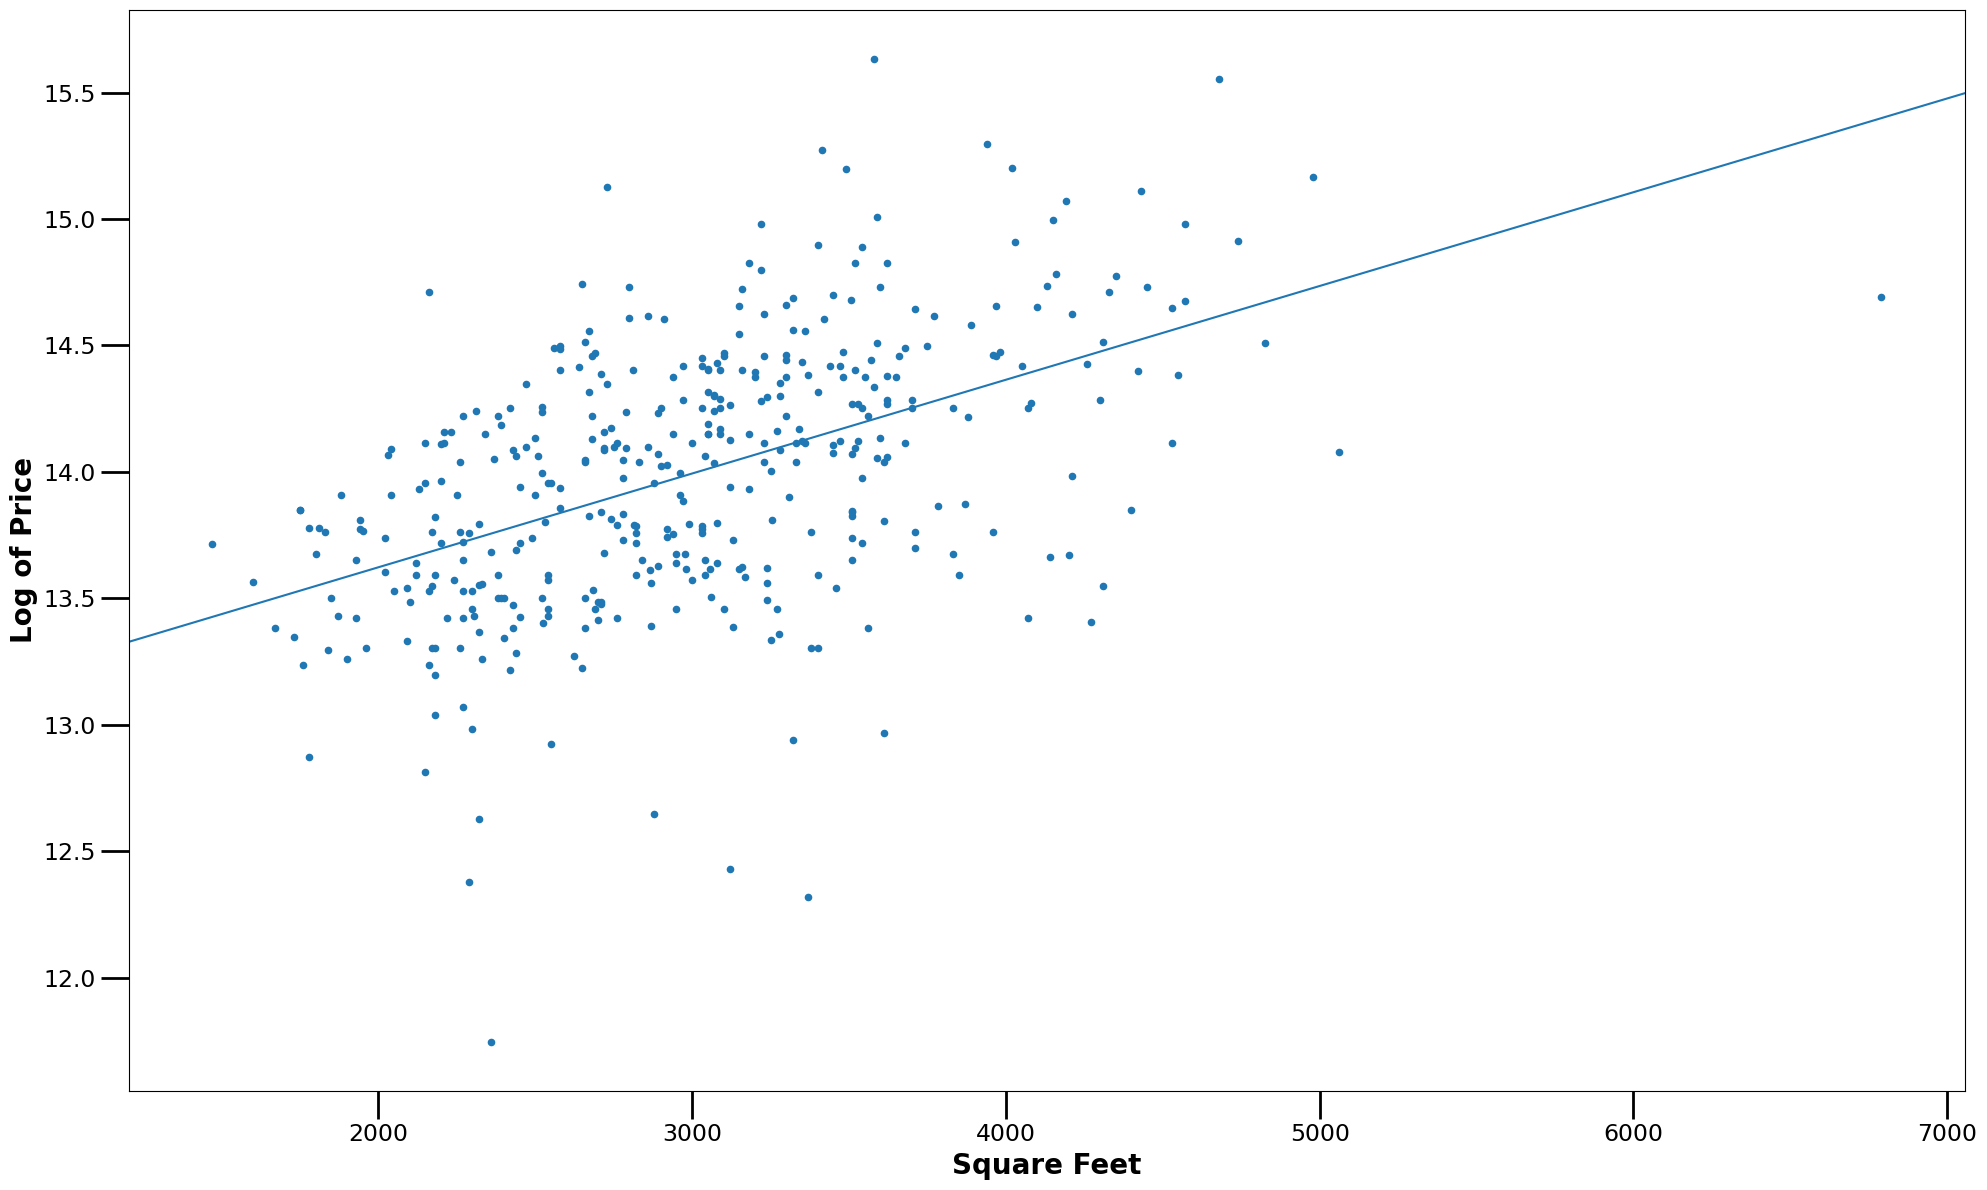

In [38]:
graph(q3_2021_x_rooms)

In [39]:
regression(q4_2021_x_rooms)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     107.3
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           9.02e-22
Time:                        20:24:53   Log-Likelihood:                -216.31
No. Observations:                 311   AIC:                             436.6
Df Residuals:                     309   BIC:                             444.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.8491      0.112    114.743      

(None, 0.48509343642349206)

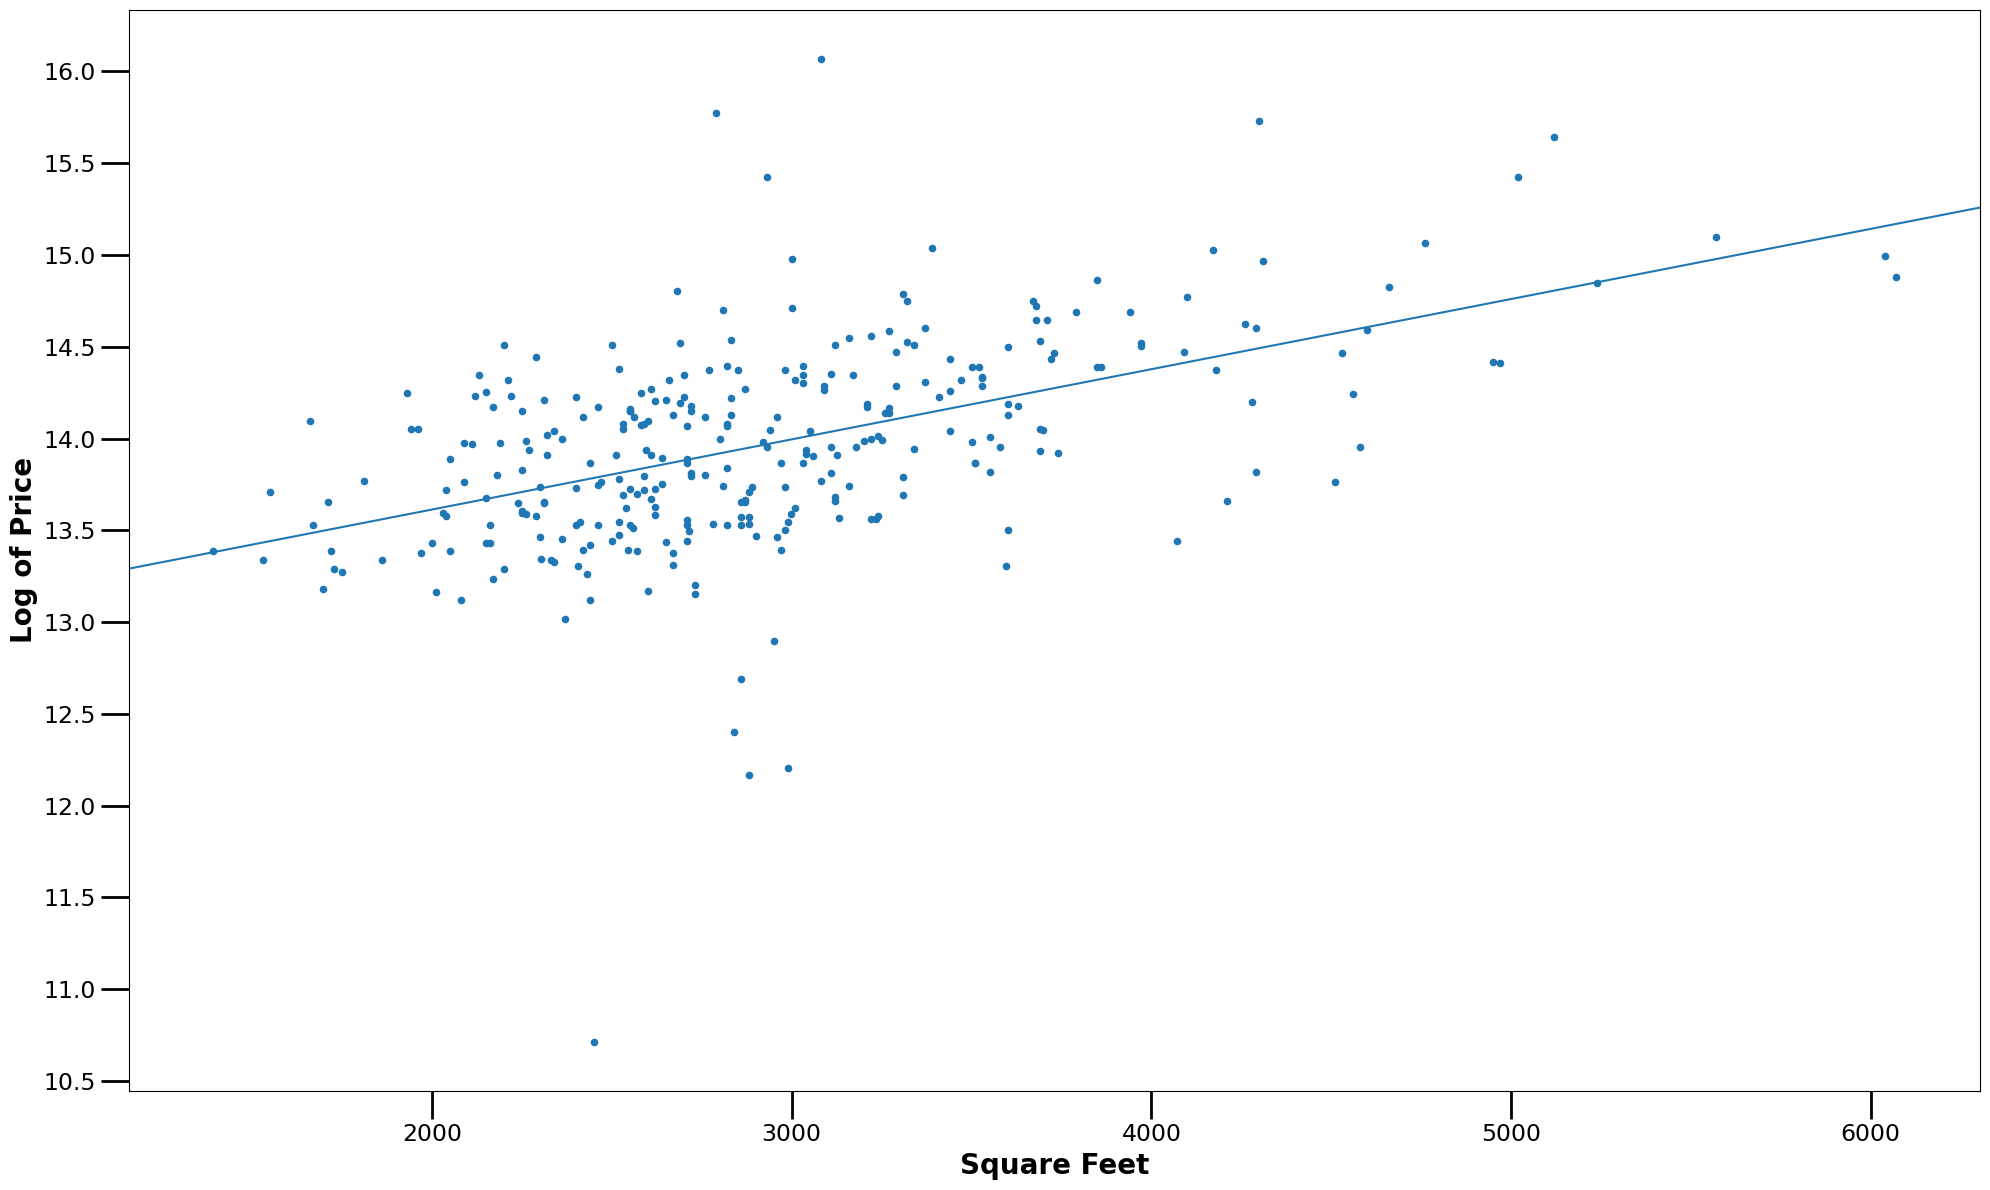

In [40]:
graph(q4_2021_x_rooms)

In [41]:
regression(q1_2022_x_rooms)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     63.77
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           1.23e-13
Time:                        20:25:01   Log-Likelihood:                -129.62
No. Observations:                 195   AIC:                             263.2
Df Residuals:                     193   BIC:                             269.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.8718      0.149     86.349      

(None, 0.47036572960635903)

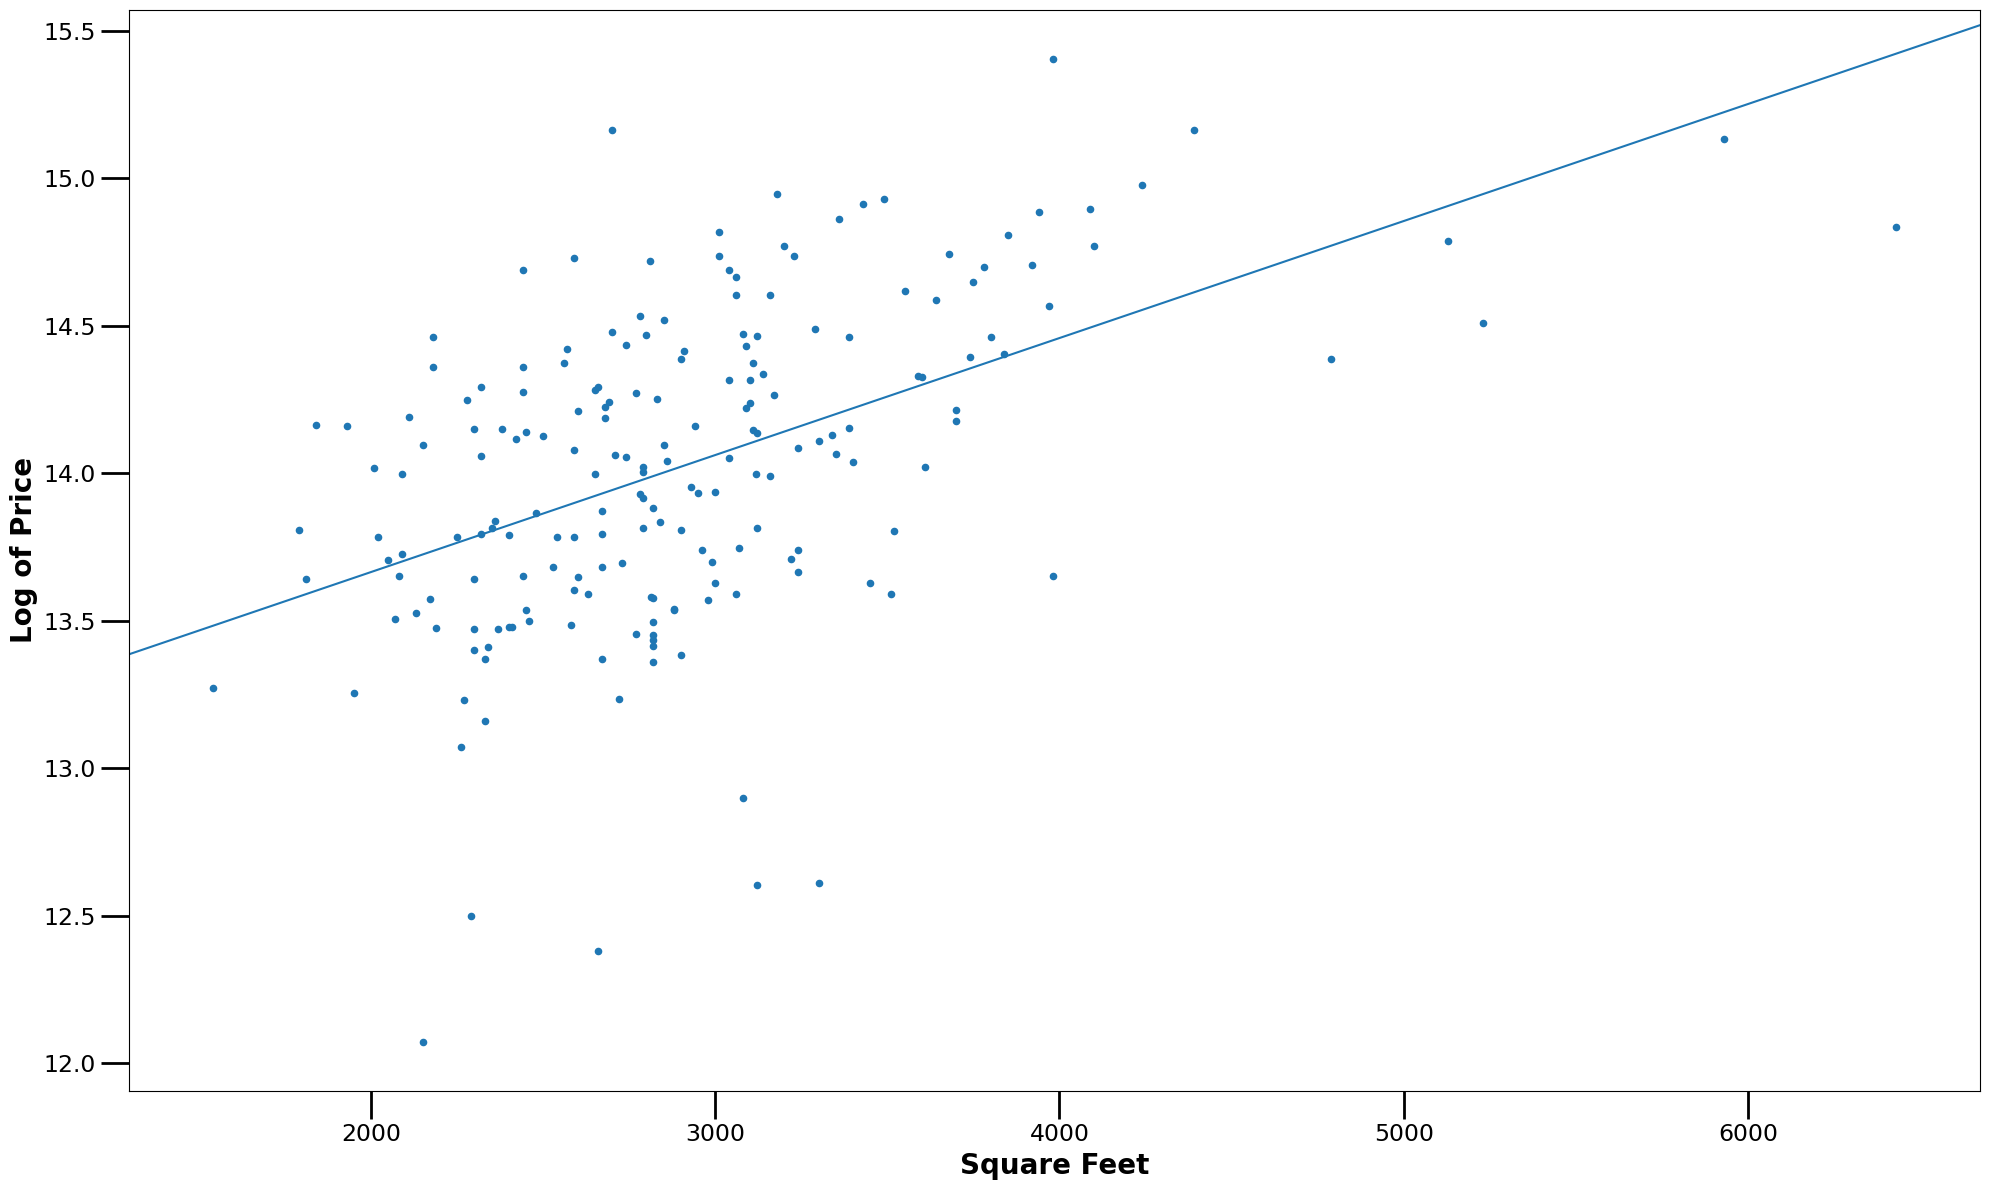

In [42]:
graph(q1_2022_x_rooms)

In [43]:
regression(q2_2022_x_rooms)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     137.3
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           2.95e-25
Time:                        20:25:03   Log-Likelihood:                -130.13
No. Observations:                 236   AIC:                             264.3
Df Residuals:                     234   BIC:                             271.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.7307      0.122    104.188      

(None, 0.41998231784425855)

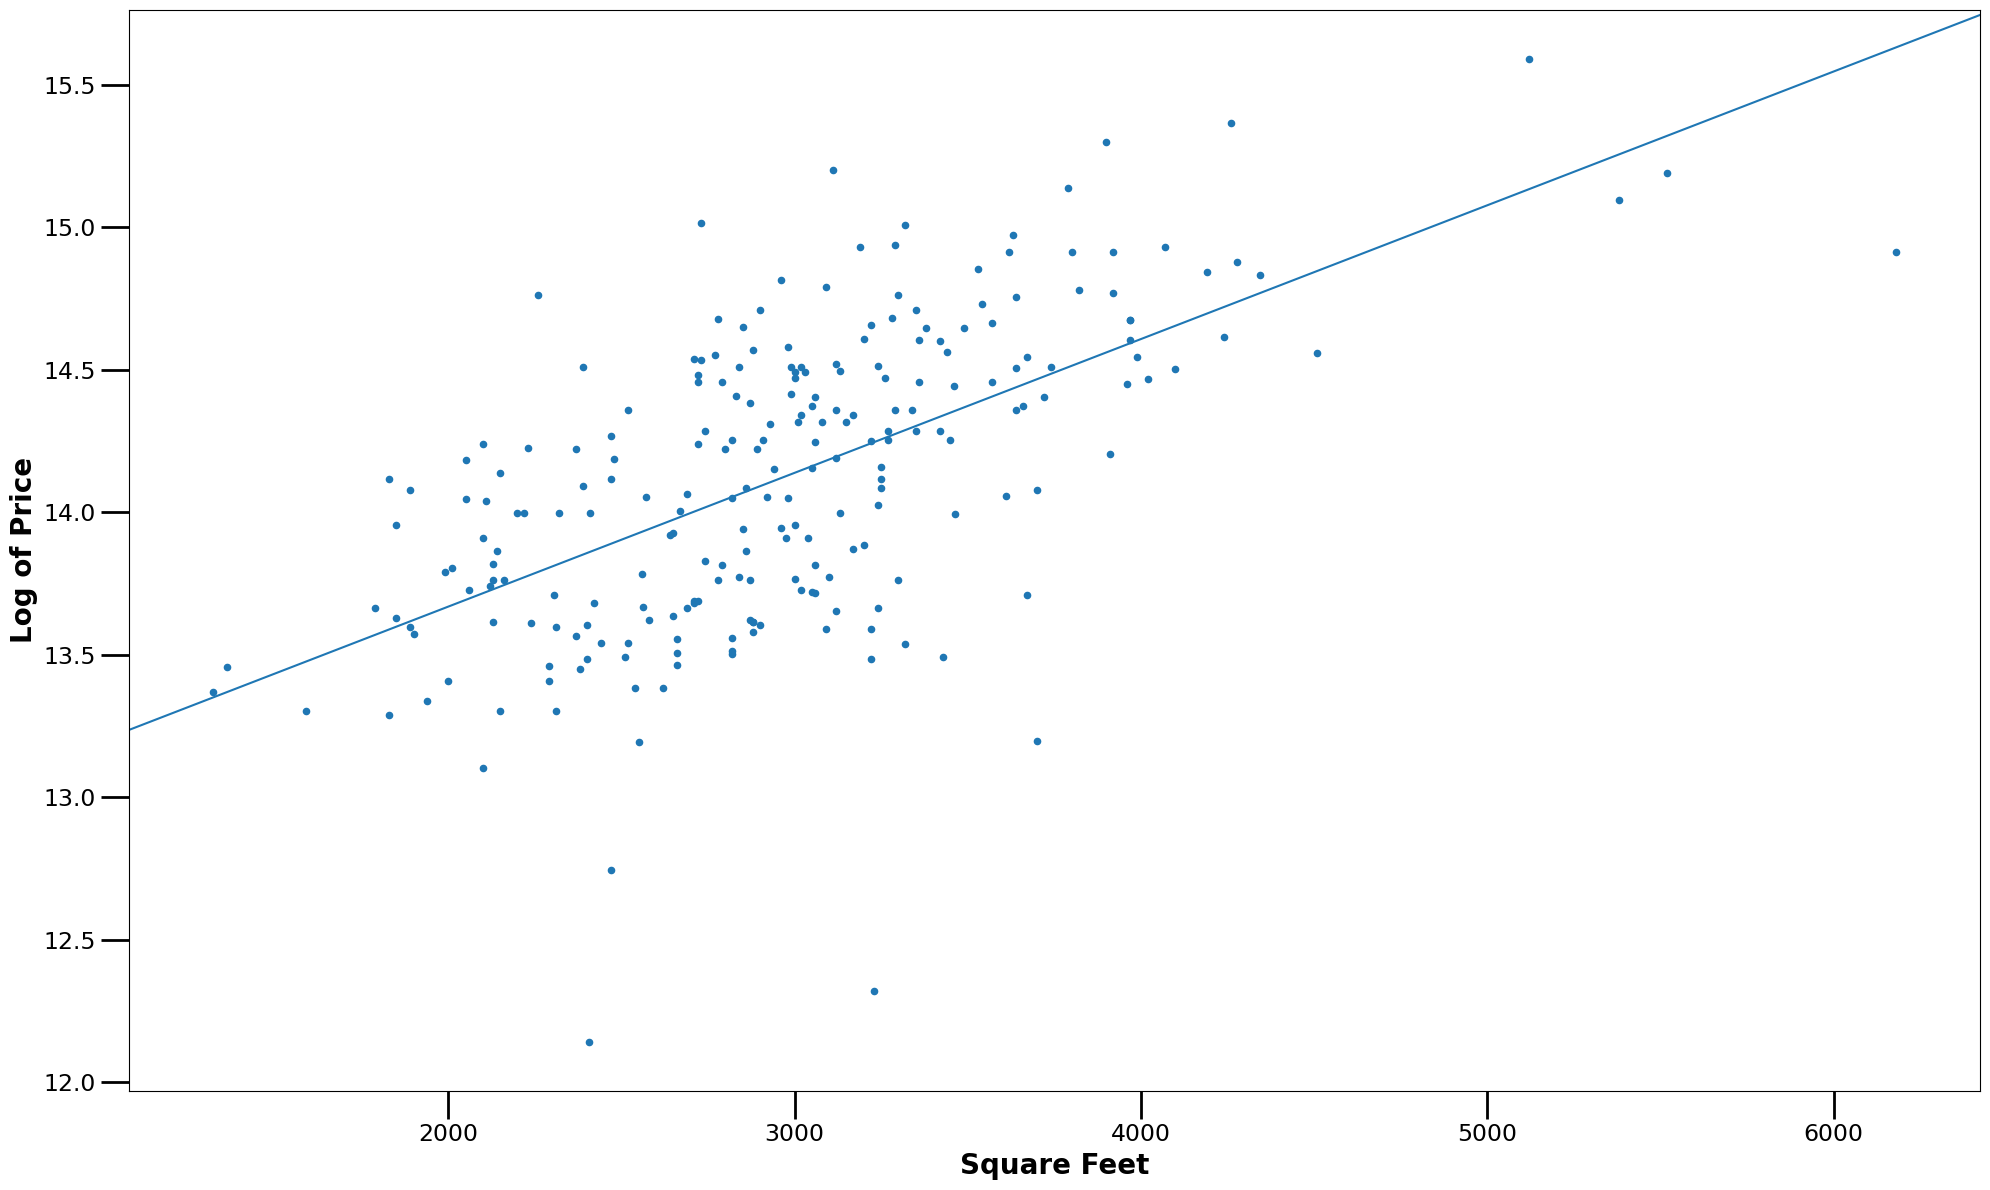

In [44]:
graph(q2_2022_x_rooms)

## Regression results

Quarters |Adj. R-Squared |Constant Coef. (P-Value) |sqft_living Coef. (P-Value) |Mean-Squared Error
:-------:|:-------------:|:-----------------------:|:--------------------------:|:----------------:
Q2 2021  |0.326          |12.86 (0.000)            |0.0004 (0.000)              |0.381
Q3 2021  |0.246          |12.88 (0.000)            |0.0004 (0.000)              |0.453
Q4 2021  |0.255          |12.85 (0.000)            |0.0004 (0.000)              |0.485
Q1 2022  |0.248          |12.87 (0.000)            |0.0004 (0.000)              |0.470
Q2 2022  |0.367          |12.73 (0.000)            |0.0005 (0.000)              |0.420

Unfortunately, these results generally have very low adjusted r-squared values. This means that the linear model can only explain less than half of the variance in `log_price`. There may be other variables that are causing low r-squared values. We can separate the homes according to their categorical values (i.e. 'condition', 'grade', or 'waterfront') in hopes of finding a more significant relationship.

Another problem with the results is that it seems like the coefficients for `sqft_living` is the same. We can plot the linear models against each other to see if that is the case.

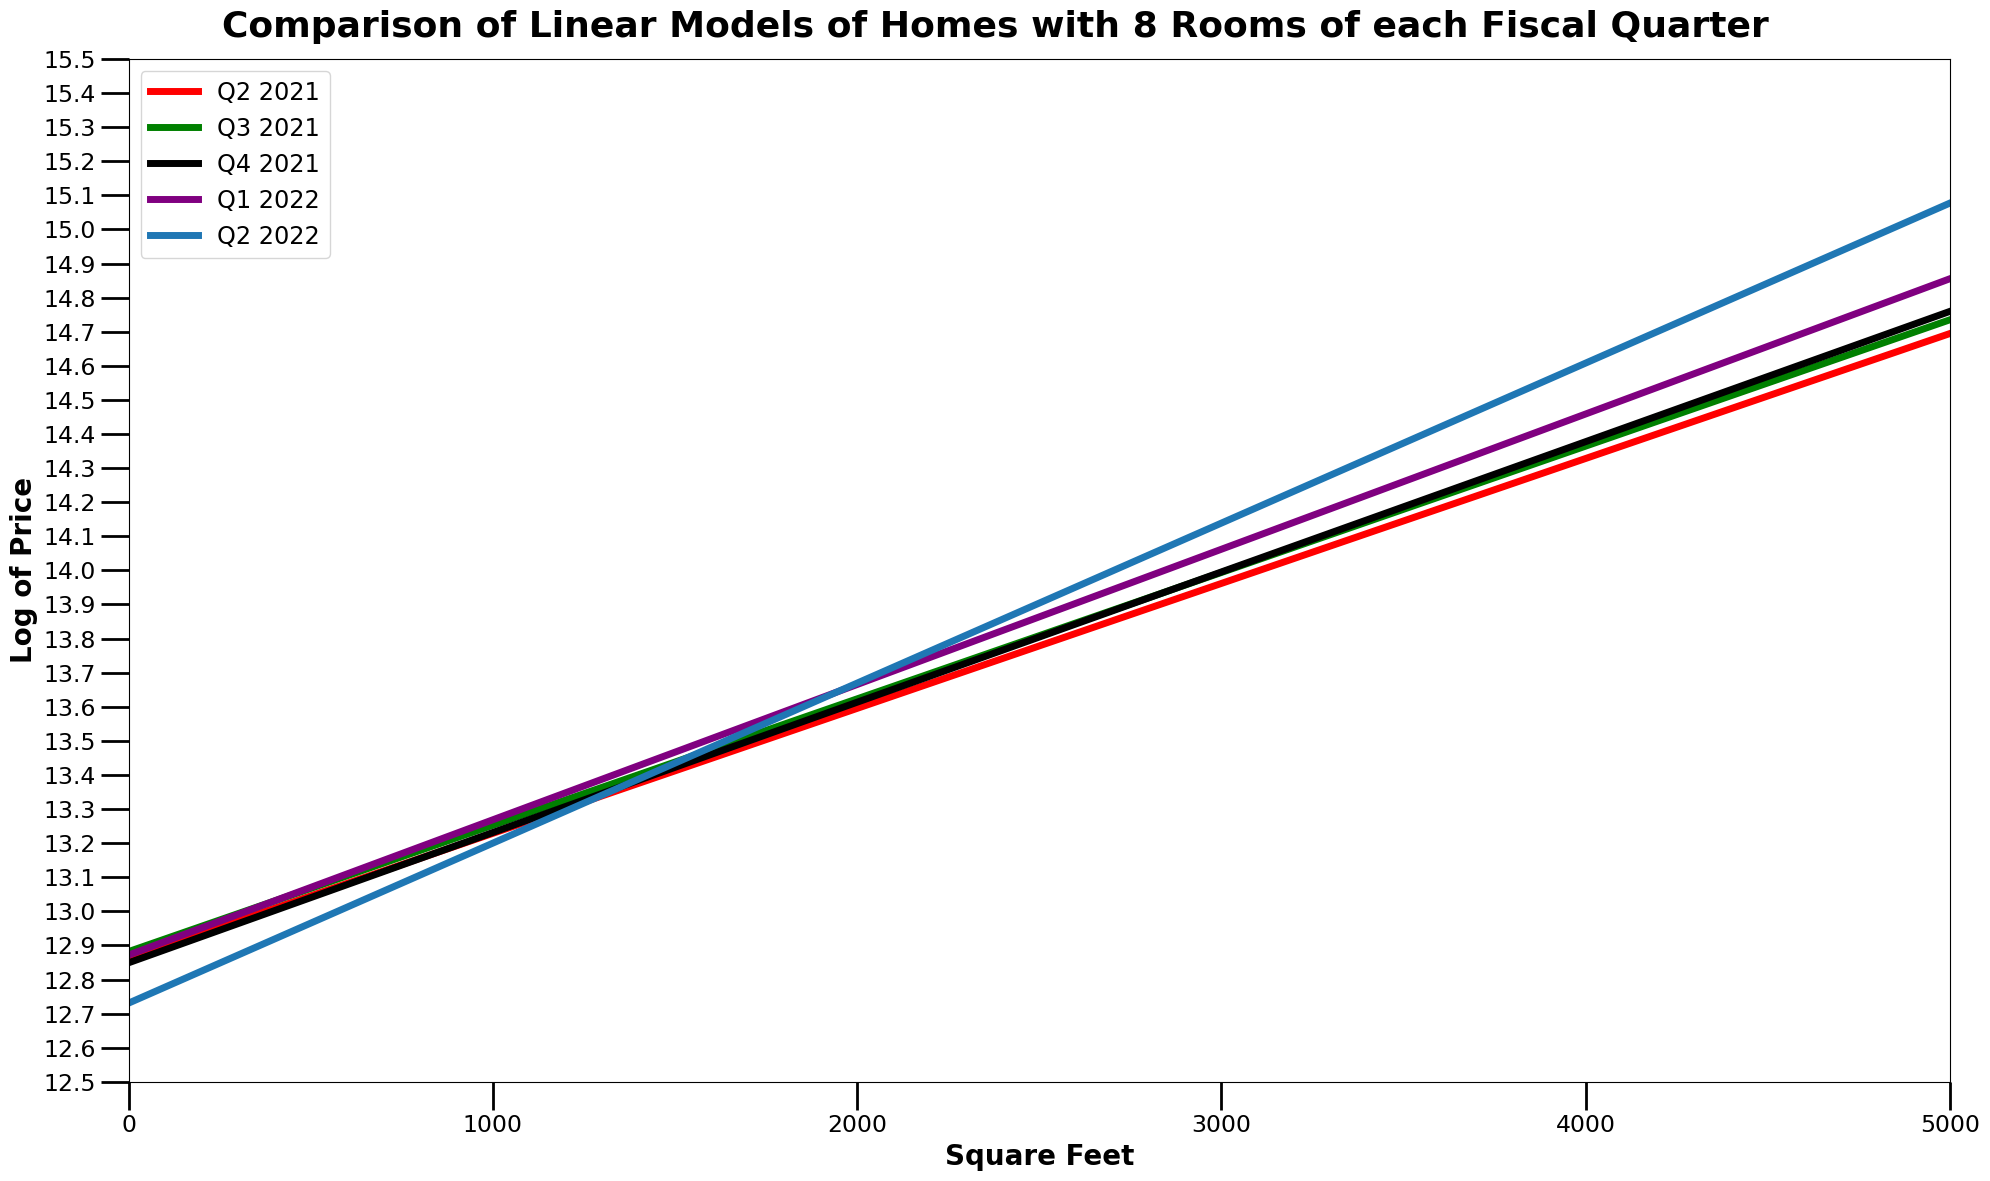

In [45]:
fig, ax = plt.subplots(figsize=(20,12), dpi=100)

sm.graphics.abline_plot(model_results=results(q2_2021_x_rooms), ax=ax, color='red', linewidth=5, label="Q2 2021")
sm.graphics.abline_plot(model_results=results(q3_2021_x_rooms), ax=ax, color='green', linewidth=5, label="Q3 2021")
sm.graphics.abline_plot(model_results=results(q4_2021_x_rooms), ax=ax, color='black', linewidth=5, label="Q4 2021")
sm.graphics.abline_plot(model_results=results(q1_2022_x_rooms), ax=ax, color='purple', linewidth=5, label="Q1 2022")
sm.graphics.abline_plot(model_results=results(q2_2022_x_rooms), ax=ax, linewidth=5, label="Q2 2022")

ax = plt.gca()
ax.set_xlim([0, 5000])
ax.set_ylim([12.5, 15.5])
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.tick_params('both', length=20, width=2, which='major')
ax.tick_params('both', length=10, width=1, which='minor')
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

fig.suptitle("Comparison of Linear Models of Homes with 8 Rooms of each Fiscal Quarter", fontweight='bold', fontsize=26)
ax.set_xlabel("Square Feet", fontsize=20, fontweight='bold')
ax.set_ylabel("Log of Price", fontsize=20, fontweight='bold')

ax.legend(fontsize='xx-large')

plt.tight_layout();

We can see that the __Q2 2022__ slope is the greatest followed by __Q1 2022__ slope. This confirms our alternative hypothesis.

# Categorical Data

Categorical data is another way to measure a home's value. These datasets come with numerous categorical columns that contain strings for values. We can investigate the values of the categorical columns with a for loop and use dummy values to assign integer values to each categorical column.
___

In order to make a predictive model, we will be looking at home prices for the most recent quarter stored in `q2_2022_x_rooms`.

In [46]:
categories = q2_2022_x_rooms.select_dtypes("object")

for col in categories:
    print(q2_2022_x_rooms[col].value_counts(), "\n")

NO     232
YES      4
Name: waterfront, dtype: int64 

NO     226
YES     10
Name: greenbelt, dtype: int64 

NO     204
YES     32
Name: nuisance, dtype: int64 

NONE         191
AVERAGE       23
GOOD          12
EXCELLENT      6
FAIR           4
Name: view, dtype: int64 

Average      156
Good          53
Very Good     26
Fair           1
Name: condition, dtype: int64 

8 Good           91
7 Average        64
9 Better         50
10 Very Good     21
11 Excellent      7
6 Low Average     3
Name: grade, dtype: int64 

Gas            199
Electricity     24
Oil             12
Other            1
Name: heat_source, dtype: int64 

PUBLIC     215
PRIVATE     21
Name: sewer_system, dtype: int64 

3903 Northeast 103rd Street, Seattle, Washington 98125, United States         1
10706 4th Avenue South, Seattle, Washington 98168, United States              1
8205 South 123rd Place, Seattle, Washington 98178, United States              1
7110 149th Avenue Northeast, Redmond, Washington 98052, United 

This for loop provides us with the values and number of occurences in the category. We see that 232 homes do not have waterfronts while 4 of homes do. By only looking at homes that do not have waterfronts, we can then see how categories like `condition` and `grade` affects the prices of homes.
___

Removing the homes that have waterfronts, located on greenbelts, and have nuisance:

In [47]:
no_waterfront = q2_2022_x_rooms.loc[q2_2022_x_rooms['waterfront'].str.contains('NO')]
no_greenbelt = no_waterfront.loc[no_waterfront['greenbelt'].str.contains('NO')]
no_nuisance = no_greenbelt.loc[no_greenbelt['nuisance'].str.contains('NO')]

This function will allow us to input the dataframe and any categorical column that we wish to observe. In return, a dataframe with dummy values will be made.

In [48]:
def category_corr_df(dataframe, cat_col):
    x = dataframe[["sqft_living"]]
    y = dataframe[["log_price"]]
    X_iterated = dataframe[["sqft_living", cat_col]]
    X_iterated = pd.get_dummies(X_iterated, columns=[cat_col])
    return X_iterated

This function will have an input of the same dataframe as the function before, but will also include the dataframe containing the dummy values created from the `category_corr_df` function. It will return results of the linear model along with the mean-squared error.

In [49]:
def cat_regression_results(dataframe, x_it):
    y = dataframe[["log_price"]]
    iterated_model = sm.OLS(y, sm.add_constant(x_it))
    iterated_results = iterated_model.fit()
    return print(iterated_results.summary()), mean_squared_error(y, iterated_results.predict(sm.add_constant(X_iterated)), squared=False)

In order to observe how the `view` affects the prices of homes, we must keep the `condition` and `grade` columns constant. We can make a new dataframe that contains the same values for these columns except the `view` column. In order to retain as much values as we can, we can look back at the value counts of each value. For this particular dataset, we can filter the dataframe so that it only contains `Average` for `condition` and `8 Good` for `grade`.

In [50]:
view_df = no_nuisance.loc[no_nuisance.condition=="Average"]
view_df = view_df.loc[view_df.grade=="8 Good"]

Now that the dataframe only contains similar values except for `view`, we can input the dataframe along with the categorical column `view` into their corresponding function.

In [51]:
X_iterated = category_corr_df(view_df, "view")
cat_regression_results(view_df, X_iterated)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     5.000
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           0.000940
Time:                        20:25:21   Log-Likelihood:                -23.749
No. Observations:                  53   AIC:                             59.50
Df Residuals:                      47   BIC:                             71.32
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.9836      0.343     32.

(None, 0.3787598708161047)

From the results we can see how each value for `view` can affect the price of a home, given that the `condition` is `Average` and the `grade` is `8 Good`. The adjusted r-squared value, despite being positively correlated, is relatively low, dictating that the view may not be as influentical in calculating the price. However, an equation can still be created by using the coefficients from the results:

### $$ \log(price) = 10.9836 + 0.0004 x_1 + 1.8776 x_2 + 2.5244 x_3 + 2.8254 x_4 + 2.0674 x_5 + 1.6887 x_6 $$

| Variable        | Meaning in This Context                |
| :-------------: | :--------------------------------------|
| $x_1$           | square feet of living space            |
| $x_2$           | view of home is average           |
| $x_3$           | view of home is excellent         |
| $x_4$           | view of home is fair              |
| $x_5$           | view of home is good              |
| $x_6$           | view of home is not graded (none) |
|_Mean-squared error_:  $0.3788$<br> |

___

We can follow the same procedure to see how different values in `condition` affects the price. Again we will look back at the value counts to see which `view` and `grade` values to keep constant. In this case, `view` is `NONE` and `grade` is `8 Good`.

In [52]:
condition_df = no_nuisance.loc[no_nuisance.view=="NONE"]
condition_df = condition_df.loc[condition_df.grade=="8 Good"]

In [53]:
X_iterated = category_corr_df(condition_df, "condition")
cat_regression_results(condition_df, X_iterated)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     7.052
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           0.000355
Time:                        20:25:23   Log-Likelihood:                -33.987
No. Observations:                  69   AIC:                             75.97
Df Residuals:                      65   BIC:                             84.91
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  10.0098    

(None, 0.395984982204871)

The r-squared value is incredibly low indicating that the price is very weakly correlated to the `condition`. However we can still construct the formula:
### $$ \log(price) = 10.0098 + 0.0003 x_1 + 3.1548 x_2 + 3.2235 x_3 + 3.6315 x_4 $$

| Variable        | Meaning in This Context                |
| :-------------: | :--------------------------------------|
| $x_1$           | square feet of living space            |
| $x_2$           | condition of home is average           |
| $x_3$           | condition of home is good         |
| $x_4$           | condition of home is very good              |
|_Mean-squared error_:  $0.3960$<br> |

___

To observe how `grade` affects home prices, we will set `view` to `NONE` and `condition` to `Average`.

In [54]:
grade_df = no_nuisance.loc[no_nuisance.view=="NONE"]
grade_df = grade_df.loc[grade_df.condition=="Average"]

In [55]:
X_iterated = category_corr_df(grade_df, "grade")
cat_regression_results(grade_df, X_iterated)

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     20.81
Date:                Fri, 24 Mar 2023   Prob (F-statistic):           3.37e-14
Time:                        20:25:25   Log-Likelihood:                -45.222
No. Observations:                 106   AIC:                             102.4
Df Residuals:                     100   BIC:                             118.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.9764      0

(None, 0.3707157746964745)

The r-squared value indicates that the price may somewhat be correlated to the grade of the home.
### $$ \log(price) = 10.9764 + 0.0004 x_1 + 2.4966 x_2 + 2.5941 x_3 + 1.7681 x_4 + 1.9212 x_5 + 2.1963 x_6 $$

Alternatively, we can rewrite the equation where the output of the equation is the price:
### $$ price = 10^{10.9764 + 0.0004 x_1 + 2.4966 x_2 + 2.5941 x_3 + 1.7681 x_4 + 1.9212 x_5 + 2.1963 x_6} $$

| Variable        | Meaning in This Context                |
| :-------------: | :--------------------------------------|
| $x_1$           | square feet of living space            |
| $x_2$           | grade of home is very good           |
| $x_3$           | grade of home is excellent        |
| $x_4$           | grade of hone is average           |
| $x_5$           | grade of home is good             |
| $x_6$           | grade of home is better         |
|_Mean-squared error_:  $0.3707$<br> |

# Conclusion
From the data provided we can make multiple conclusions. One of which is that the price of homes seem to fluctuate throughout the year of 2021. This maybe due to the unstablity caused by COVID-19. However, the prices of homes seem to be in an upward trend as of the second quarter of 2022. To further investigate this hypothesis, we can observe the demand of the homes in King County by looking at factors like employment and migration rate of the area. Another factor that may influence the housing market may also be mortgage rates. As mortgage rates increase it may be difficult to purchase a home which may cause consumers to rent property instead.

Another conclusion we can make is that `grade`, `view`, and `condition` of a home is weakly correlated in determining its price. As mentioned before, mortgage rates may be the more important factor that drives the housing market. It would also be interesting to look at how mortgage rates influence the size of houses purchased. Unfortunately, this dataset only allows us to conclude that these categorical values have a small positive impact on home prices.